## LOADING LIBRARIES

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

## LOADING DATASET-LABELS

In [2]:
train = pd.read_csv('new_eye_data.csv', encoding='ISO-8859-1')    # reading the csv file
train.head()      # printing first five rows of the file

,Image name,Ophthalmologic department,Retinopathy grade,Risk of macular edema
0,20051216_43814_0200_PP.tif,CHU de St Etienne,0,0
1,20051216_43913_0200_PP.tif,CHU de St Etienne,0,0
2,20051216_44066_0200_PP.tif,CHU de St Etienne,0,0
3,20051216_44092_0200_PP.tif,CHU de St Etienne,0,0
4,20051216_44221_0200_PP.tif,CHU de St Etienne,0,0


In [3]:
train = train[['Image name', 'Retinopathy grade']]
train.head()

,Image name,Retinopathy grade
0,20051216_43814_0200_PP.tif,0
1,20051216_43913_0200_PP.tif,0
2,20051216_44066_0200_PP.tif,0
3,20051216_44092_0200_PP.tif,0
4,20051216_44221_0200_PP.tif,0


## CREATING HISTOGRAM EQUALISATION

In [4]:
def get_histogram(image, bins):
    # array with size of bins, set to zeros
    histogram = np.zeros(bins)

    # loop through pixels and sum up counts of pixels
    for pixel in image:
        histogram[pixel] += 1

    # return our final result
    return histogram

## CREATING CUMMULATIVE SUM FUNCTION

In [5]:
def cumsum(a):
    a = iter(a)
    b = [next(a)]
    for i in a:
        b.append(b[-1] + i)
    return np.array(b)

## LOADING IMAGE DATASET AND PREPROCESSING

In [6]:
scale_percent = 60
train_image = []
for i in tqdm(range(train.shape[0])):
    image = cv2.imread('eye_data/'+train['Image name'][i])

    # resize image
    #width = int(image.shape[1] * scale_percent / 100)
    #height = int(image.shape[0] * scale_percent / 100)
    dim = (200, 200)
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    RGBimg = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    img_t = cv2.addWeighted(RGBimg,4, cv2.GaussianBlur(RGBimg , (0,0) , 30) ,-4 ,128)
    gray = cv2.cvtColor(img_t, cv2.COLOR_RGB2GRAY)
    flat = gray.flatten()
    hist = get_histogram(flat, 256)
    cs = cumsum(hist)
    nj = (cs - cs.min()) * 255
    N = cs.max() - cs.min()
    # re-normalize the cumsum
    cs = nj / N
    # cast it back to uint8 since we can't use floating point values in images
    cs = cs.astype('uint8')
    img_new = cs[flat]
    img_new = np.reshape(img_new, gray.shape)
    train_image.append(img_new)

X = np.array(train_image)

100%|██████████| 1200/1200 [02:03<00:00,  9.71it/s]


In [7]:
X.shape

(1200, 200, 200)

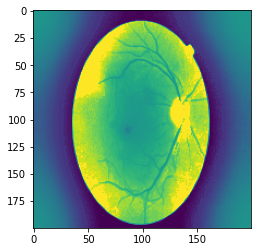

In [8]:
plt.imshow(X[2])

In [9]:
y = np.array(train.drop(['Image name'],axis=1))
y.shape

(1200, 1)

In [10]:
y = y.reshape(-1)

In [11]:
y.shape

(1200,)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [13]:
print(X_train.shape)
print(X_test.shape)


(960, 200, 200)
(240, 200, 200)


In [14]:
X_train = X_train.reshape(-1, 200, 200, 1)
X_test = X_test.reshape(-1, 200, 200, 1)

In [15]:
print(X_train.shape)
print(X_test.shape)


(960, 200, 200, 1)
(240, 200, 200, 1)


## LOADING SAVED MODEL

In [16]:
with tf.device('/device:CPU:0'):
 reconstructed_model = keras.models.load_model("final_95.83_model.h5")

In [17]:
reconstructed_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 200, 200, 64)      640       
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 100, 100, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_121 (Conv2D)         (None, 100, 100, 128)     73856     
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 50, 50, 128)      0         
 g2D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 320000)            0         
                                                                 
 dense_83 (Dense)            (None, 128)             

## MODEL PREDICTION (on training set)

In [18]:
with tf.device('/device:CPU:0'):
    y_pred = reconstructed_model.predict(X)
    y_class=np.argmax(y_pred,axis=1)

## MODEL EVALUATION<BR>
1) ACCURACY
2) PRECISION
3) RECALL
4) F1 SCORE

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y, y_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y, y_class, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y, y_class, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y, y_class, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.873333
Precision: 0.873491
Recall: 0.873333
F1 score: 0.872853
